# 한국어 띄어쓰기 모델 학습 코드

240625

- [ref](https://github.com/haven-jeon/TrainKoSpacing.git)

> git clone https://github.com/haven-jeon/TrainKoSpacing.git)

- 완성, 학습중, pip 버전으로 변경

# Train

In [11]:
## setup
# pip intall torch==2.3.0
# pip intall transformers==4.40.0
# pip install gensim==4.3.2

In [12]:
# import
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, random_split
import torch.nn.functional as F
# from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os
import re
from collections import Counter
from pprint import pprint



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

def seed_everything(random_seed=777):
    # 모든 seed 고정
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)
seed_everything(777)

/tmp/ipykernel_66094/3007788194.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [39]:
## config
def get_parser():
    parser = argparse.ArgumentParser(description='Korean Autospacing Trainer')
    parser.add_argument('--num-epoch',
                        type=int,
                        default=20,
                        help='number of iterations to train (default: 5)')

    parser.add_argument('--n-hidden',
                        type=int,
                        default=200,
                        help='GRU hidden size (default: 200)')

    parser.add_argument('--max-seq-len',
                        type=int,
                        default=200,
                        help='max sentence length on input (default: 200)')

    parser.add_argument('--num-gpus',
                        type=int,
                        default=1,
                        help='number of gpus (default: 1)')

    parser.add_argument('--train',
                        action='store_true',
                        default=False,
                        help='do trainig (default: False)')

    parser.add_argument('--train-samp-ratio',
                        type=float,
                        default=0.5,
                        help='random train sample ration (default: 0.50)')

    parser.add_argument('--batch_size',
                        type=int,
                        default=100,
                        help='train batch size')

    parser.add_argument('--test_batch_size',
                        type=int,
                        default=100,
                        help='test batch size')

    parser.add_argument('--n_workers',
                        type=int,
                        default=10,
                        help='number of dataloader workers')

    parser.add_argument('--train_data',
                        type=str,
                        default='data/UCorpus_spacing_train.txt.bz2',
                        help='bziped train data')

    parser.add_argument('--test_data',
                        type=str,
                        default='data/UCorpus_spacing_test.txt.bz2',
                        help='bziped test data')

    parser.add_argument('--model_type',
                        type=str,
                        default='kospacing',
                        help='kospacing or kospacing2')

    parser.add_argument('--outputs',
                        type=str,
                        default='outputs',
                        help='directory to save log and model params')

    opt = parser.parse_args(args=[])
    return opt

opt = get_parser()
opt.bath_size = 64
# opt.bath_size = 2
# opt.sampling = 0.00101
opt.sampling = 1
opt.train_samp_ratio=0.95
opt.make_lag_set = True  # n gram 8단어 이하로 데이터 증강 시도
opt.learning_rate = 0.0001

opt.SAVE_OUTPUT = './output_test'
opt.vocab_file = './resources/w2idx.dic'
opt.data_path_json = './data/train_corpus.txt'  # 학습 데이터, 1줄에 1문장으로 이루어진 txt파일로 구성
opt.EPOCHS = 2

# is_test = True
is_test = False

In [40]:
# functions
__all__ = [
    'create_embeddings', 'load_embedding', 'load_vocab',
    'encoding_and_padding', 'get_embedding_model'
]

import bz2
import json
import os

import numpy as np
import pkg_resources
from gensim.models import Word2Vec

def sent_to_spacing_chars(sent):
    # 공백은 ^
    chars = sent.strip().replace(' ', '^')
    # char_list = [li.strip().replace(' ', '^') for li in sents]

    # 문장의 시작 포인트 «
    # 문장의 끌 포인트  »
    tagged_chars = "«" + chars + "»"
    # char_list = [ "«" + li + "»" for li in char_list]

    # 문장 -> 문자열
    char_list = ' '.join(list(tagged_chars))
    # char_list = [ ' '.join(list(li))  for li in char_list]
    return(char_list)


def pad_sequences(sequences,
                  maxlen=None,
                  dtype='int32',
                  padding='pre',
                  truncating='pre',
                  value=0.):

    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' %
                             truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError(
                'Shape of sample %s of sequence at position %s is different from expected shape %s'
                % (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


def create_embeddings(data_dir,
                      model_file,
                      embeddings_file,
                      vocab_file,
                      splitc=' ',
                      **params):
    """
    making embedding from files.
    :**params additional Word2Vec() parameters
    :splitc   char for splitting in  data_dir files
    :model_file output object from Word2Vec()
    :data_dir data dir to be process
    :embeddings_file numpy object file path from Word2Vec()
    :vocab_file item to index json dictionary
    """
    class SentenceGenerator(object):
        def __init__(self, dirname):
            self.dirname = dirname

        def __iter__(self):
            for fname in os.listdir(self.dirname):
                print("processing~  '{}'".format(fname))
                for line in bz2.open(os.path.join(self.dirname, fname), "rt"):
                    yield sent_to_spacing_chars(line.strip()).split(splitc)

    sentences = SentenceGenerator(data_dir)

    model = Word2Vec(sentences, **params)
    model.save(model_file)
    # model = Word2Vec.load("model_2.w2v")
    weights = model.wv.syn0
    default_vec = np.mean(weights, axis=0, keepdims=True)
    padding_vec = np.zeros((1, weights.shape[1]))

    weights_default = np.concatenate([weights, default_vec, padding_vec],
                                     axis=0)

    np.save(open(embeddings_file, 'wb'), weights_default)

    vocab = dict([(k, v.index) for k, v in model.wv.vocab.items()])
    vocab['__ETC__'] = weights_default.shape[0] - 2
    vocab['__PAD__'] = weights_default.shape[0] - 1
    with open(vocab_file, 'w') as f:
        f.write(json.dumps(vocab))


def load_embedding(embeddings_file):
    return (np.load(embeddings_file))


def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word


def encoding_and_padding(word2idx_dic, sequences, **params):
    """
    1. making item to idx
    2. padding
    :word2idx_dic
    :sequences: list of lists where each element is a sequence
    :maxlen: int, maximum length
    :dtype: type to cast the resulting sequence.
    :padding: 'pre' or 'post', pad either before or after each sequence.
    :truncating: 'pre' or 'post', remove values from sequences larger than
        maxlen either in the beginning or in the end of the sequence
    :value: float, value to pad the sequences to the desired value.
    """
    seq_idx = [[word2idx_dic.get(a, word2idx_dic['__ETC__']) for a in i]
               for i in sequences]
    params['value'] = word2idx_dic['__PAD__']
    return (pad_sequences(seq_idx, **params))


def get_embedding_model(name='fee_prods', path='data/embedding'):
    weights = pkg_resources.resource_filename(
        'dsc', os.path.join(path, name, 'weights.np'))
    w2idx = pkg_resources.resource_filename(
        'dsc', os.path.join(path, name, 'idx.json'))
    return ((load_embedding(weights), load_vocab(w2idx)[0]))



def make_input_data(inputs,
                    train_ratio,
                    sampling,
                    make_lag_set=False,
                    batch_size=200):
    with bz2.open(inputs, 'rt') as f:
        line_list = [i.strip() for i in f.readlines() if i.strip() != '']
    logger.info('complete loading train file!')

    # 아버지가 방에 들어가신다. -> '«아버지가^방에^들어가신다.»'
    processed_seq = pre_processing(line_list)
    logger.info(processed_seq[0])
    # n percent random sample
    logger.info('random sampling on training set!')
    samp_idx = np.random.choice(range(len(processed_seq)),
                                int(len(processed_seq) * sampling),
                                replace=False)
    processed_seq_samp = [processed_seq[i] for i in samp_idx]
    sp_sents = [i.split('^') for i in processed_seq_samp]

    sp_sents = list(filter(lambda x: len(x) >= 8, sp_sents))

    # max 8 어절 씩 1어절 shift하여 학습 데이터 생성
    if make_lag_set is True:
        n_gram = [[k, v, z, a, c, d, e, f]
                  for sent in sp_sents for k, v, z, a, c, d, e, f in zip(
                      sent, sent[1:], sent[2:], sent[3:], sent[4:], sent[5:],
                      sent[6:], sent[7:])]
    else:
        n_gram = sp_sents
    # max 200문자 이하만 사용
    n_gram = [i for i in n_gram if len("^".join(i)) <= opt.max_seq_len]
    # y 정답 인코딩
    n_gram_y = y_encoding(n_gram, opt.max_seq_len)
    logger.info(n_gram[0])
    logger.info(n_gram_y[0])
    # vocab file 로딩
    w2idx, _ = load_vocab(opt.vocab_file)

    # 학습셋을 만들기 위해 공백을 제거하고 문자 인덱스로 인코딩함
    logger.info('index eocoding!')
    ngram_coding_seq = encoding_and_padding(
        word2idx_dic=w2idx,
        sequences=[''.join(gram) for gram in n_gram],
        maxlen=opt.max_seq_len,
        padding='post',
        truncating='post')
    logger.info(ngram_coding_seq[0])
    if train_ratio < 1:
        # 학습셋 테스트셋 생성
        tr_idx, te_idx = split_train_set(ngram_coding_seq, train_ratio)

        y_train = n_gram_y[tr_idx, ]
        x_train = ngram_coding_seq[tr_idx, ]

        y_test = n_gram_y[te_idx, ]
        x_test = ngram_coding_seq[te_idx, ]

        # train generator
        train_generator = get_generator(x_train, y_train, batch_size)
        valid_generator = get_generator(x_test, y_test, 500)
        return (train_generator, valid_generator)
    else:
        train_generator = get_generator(ngram_coding_seq, n_gram_y, batch_size)
        return (train_generator)


def pre_processing(setences):
    # 공백은 ^
    char_list = [li.strip().replace(' ', '^') for li in setences]
    # 문장의 시작 포인트 «
    # 문장의 끌 포인트  »
    char_list = ["«" + li + "»" for li in char_list]
    # 문장 -> 문자열
    char_list = [''.join(list(li)) for li in char_list]
    return char_list


def y_encoding(n_grams, maxlen=200):
    # 입력된 문장으로 정답셋 인코딩함
    # 띄어쓰기 위치에 1 채움
    init_mat = np.zeros(shape=(len(n_grams), maxlen), dtype=np.int8)
    for i in range(len(n_grams)):
        init_mat[i, np.cumsum([len(j) for j in n_grams[i]]) - 1] = 1
    return init_mat


def split_train_set(x_train, p=0.98):
    """
    > split_train_set(pd.DataFrame({'a':[1,2,3,4,None], 'b':[5,6,7,8,9]}))
    (array([0, 4, 3]), [1, 2])
    """
    import numpy as np
    train_idx = np.random.choice(range(x_train.shape[0]),
                                 int(x_train.shape[0] * p),
                                 replace=False)
    set_tr_idx = set(train_idx)
    test_index = [i for i in range(x_train.shape[0]) if i not in set_tr_idx]
    return ((train_idx, np.array(test_index)))

In [41]:
# 사전 파일 로딩
w2idx, idx2w = load_vocab(opt.vocab_file)  # 1994, w2idx: '엠': 1352
# 임베딩 파일 로딩
vocab_size = 1994

In [42]:
## get list of lines
with open(opt.data_path_json, 'r', encoding='utf-8') as f_read:
    lines = f_read.readlines()
    list_sentence = [tmp.strip() for tmp in lines]
    print(f'Num of Sentence: {len(list_sentence)}')
print(list_sentence[:3])

Num of Sentence: 75
['비 내린 직후에 따릉이를 타본 적 있는가.', "십중팔구 '젖은 안장' 때문에 불편함을 겪었을 거다.", '이유는 별다른 게 아니다.']


In [44]:
## data preprocessing
# train data 선택, 8단어 이상 전처리
# config
# list_sentence
# sampling = 0.001
# make_lag_set = True
# train_ratio = 0.90

# 아버지가 방에 들어가신다. -> '«아버지가^방에^들어가신다.»'
processed_seq = pre_processing(list_sentence)
print(f'{list_sentence[0]} \n=> {processed_seq[0]}')

# n percent random sample
print('## random sampling on training set!')
# sapling ration 만큼 idx 선택
samp_idx = np.random.choice(range(len(processed_seq)),
                            int(len(processed_seq) * opt.sampling),
                            replace=False)
processed_seq_samp = [processed_seq[i] for i in samp_idx]
sp_sents = [i.split('^') for i in processed_seq_samp]
sp_sents = list(filter(lambda x: len(x) >= 8, sp_sents))  # 8단어 이상만 학습데이터로 선택
print(f'{sp_sents[0]}')


# max 8 어절 씩 1어절 shift하여 학습 데이터 생성, 긴 문장은 8어절씩 시프트 하여 데이터 쪼개기
if opt.make_lag_set is True:
    n_gram = [[k, v, z, a, c, d, e, f]
              for sent in sp_sents for k, v, z, a, c, d, e, f in zip(
                  sent, sent[1:], sent[2:], sent[3:], sent[4:], sent[5:],
                  sent[6:], sent[7:])]
else:
    n_gram = sp_sents

# max 200글자 이하만 사용
n_gram = [i for i in n_gram if len("^".join(i)) <= opt.max_seq_len]
print(f'{n_gram[0]}')

# y 정답 인코딩
n_gram_y = y_encoding(n_gram, opt.max_seq_len)  # N, 200
print(f'{n_gram[0]} \n=> {n_gram_y[0]}')

# vocab file 로딩
w2idx, _ = load_vocab(opt.vocab_file)

print('## index eocoding!')
# 문장을 띄어쓰기 없이 이어부치고, char2idx를 수행, padding
ngram_coding_seq = encoding_and_padding(
    word2idx_dic=w2idx,
    sequences=[''.join(gram) for gram in n_gram],
    maxlen=opt.max_seq_len,
    padding='post',
    truncating='post')

print(f'{n_gram[0]} \n=> {ngram_coding_seq[0]}')


## train/valid dataset
# X: array([  98,  193,   52,   32,   15,   83,  371,   59,    2,   51,   25, 247,   36,    6,  415,   15,  332,   19,   96,  316,   28,   28, 29,   48,   44,  156,    7,  167,   98,   91, 1993, ..])
# Y: array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..] 

비 내린 직후에 따릉이를 타본 적 있는가. 
=> «비^내린^직후에^따릉이를^타본^적^있는가.»
## random sampling on training set!
['«안장에', '물기가', '그대로', '남아', '있는', '경우가', '숱해서다.', '영찬씨는', '이렇게', '반문했다.»']
['«안장에', '물기가', '그대로', '남아', '있는', '경우가', '숱해서다.', '영찬씨는']
['«안장에', '물기가', '그대로', '남아', '있는', '경우가', '숱해서다.', '영찬씨는'] 
=> [0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
## index eocoding!
['«안장에', '물기가', '그대로', '남아', '있는', '경우가', '숱해서다.', '영찬씨는'] 
=> [   3   94   54    7  116   19   11   17   31   15  156   26   30    6
   87   63   11 1310   36   18    2    5  138  445  223    6 1993 1993
 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993
 1993 1993

In [45]:
# 데이터 준비
class TextDataset(Dataset):
    def __init__(self, encoded_texts, tokenlevel_labels, original):
        self.encoded_texts = encoded_texts
        self.tokenlevel_labels = tokenlevel_labels
        self.original = original
    
    def __len__(self):
        return len(self.encoded_texts)
    
    def __getitem__(self, idx):
        result = {
            'X': torch.tensor(self.encoded_texts[idx], dtype=torch.long),
#             'Y': torch.tensor(self.tokenlevel_labels[idx], dtype=torch.float),
            'Y': torch.tensor(self.tokenlevel_labels[idx], dtype=torch.long),            
            'original': ' '.join(self.original[idx])  # string으로
        }
        return result 
    
    
dataset = TextDataset(encoded_texts=ngram_coding_seq, tokenlevel_labels=n_gram_y, original=n_gram)  # 98.5가 100token


if opt.train_samp_ratio < 1:
    
    # 데이터셋 분할
    train_size = int(opt.train_samp_ratio * len(dataset))
    test_size = (len(dataset) - train_size) // 2
    val_size = len(dataset) - train_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"Dataset size(train:valid:test) = {len(train_dataset)}:{len(val_dataset)}:{len(test_dataset)}")

    # 데이터 로더 설정
    train_loader = DataLoader(train_dataset, batch_size=opt.bath_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=opt.bath_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=opt.bath_size, shuffle=False)

    print(f"Dataloader size with batch_size: {opt.bath_size} | (train:valid:test) = {len(train_loader)}:{len(val_loader)}:{len(test_loader)}")

else:
    train_dataset = dataset
    print(f"Dataset size(train:valid:test) = {len(train_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=opt.bath_size, shuffle=False)
    print(f"Dataloader size with batch_size: {opt.bath_size} | (train:valid:test) = {len(train_loader)}")

Dataset size(train:valid:test) = 166:5:4
Dataloader size with batch_size: 64 | (train:valid:test) = 3:1:1


In [46]:
# CNN-LSTM 모델 정의
class CNN_GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, hidden_dim, output_dim, dropout):
        super(CNN_GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim))
            for fs in filter_sizes
        ])
        
#         self.gru = nn.GRU(num_filters * len(filter_sizes), hidden_dim, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(num_filters * len(filter_sizes), hidden_dim, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_dim * 2, 100)
        self.fc2 = nn.Linear(100, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)  # Add channel dimension
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = torch.cat(pooled, dim=1).unsqueeze(1).repeat(1, x.size(1), 1)
        
#         gru_out, _ = self.gru(cat)
        gru_out, _ = self.lstm(cat)      
        gru_out = self.dropout(gru_out)
        
        fc1_out = F.relu(self.fc1(gru_out))
        output = torch.sigmoid(self.fc2(fc1_out)).squeeze(-1)
        
        return output
    
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)

    def forward(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        attn_weights = self.context_vector(attn_weights).squeeze(-1)
        attn_weights = F.softmax(attn_weights, dim=1)
        context_vector = attn_weights.unsqueeze(-1) * lstm_output
        return context_vector, attn_weights


class CNN_LSTM_Attention_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, hidden_dim, output_dim, dropout):
        super(CNN_LSTM_Attention_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim))
            for fs in filter_sizes
        ])
        
        self.lstm = nn.LSTM(num_filters * len(filter_sizes), hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim * 2, 100)
        self.fc2 = nn.Linear(100, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)  # Add channel dimension
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = torch.cat(pooled, dim=1).unsqueeze(1).repeat(1, x.size(1), 1)
        
        lstm_out, _ = self.lstm(cat)
        lstm_out = self.dropout(lstm_out)  # [64, 200, 256]
        
#         print(f'## 1\n{lstm_out.shape}')
        
        context_vector, attention_weights = self.attention(lstm_out)  # [64, 200, 256]
        
#         print(f'## 2\n{context_vector.shape}')
        
        fc1_out = F.relu(self.fc1(context_vector))
        output = torch.sigmoid(self.fc2(fc1_out)).squeeze(-1)  # [64, 200]
        
#         print(f'## 3\n{output.shape}')
        
        return output  #, attention_weights
    
    
class CharLevelLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes=1, num_layers=1, dropout=0.5):
        super(CharLevelLSTM, self).__init__()
        
        self.num_classes = num_classes
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embed_size)
        x, (h_n, c_n) = self.lstm(x)  # (batch_size, seq_length, hidden_size)
        
        # Apply the fully connected layer to each time step
        x = self.fc(x)  # (batch_size, seq_length, num_classes)
        
        return x.squeeze(-1)  # (batch_size, seq_length)

In [47]:
# 하이퍼파라미터 설정
config_model_vocab_size = vocab_size
config_model_embed_dim = 256
config_model_num_filters = 128
config_model_filter_sizes = [2, 3, 4, 5]  # 다양한 크기의 필터 사용
config_model_hidden_dim = 256
config_model_output_dim = 2  # binary
config_model_dropout = 0.3
config_model_num_layers = 3
config_model_pad_token=1993  # padding 무시하고 loss를 구하기 위해

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1")# if torch.cuda.is_available() else "cpu")

# 모델, 손실 함수 및 옵티마이저 정의
# model = CNN_GRU_Model(config_model_vocab_size, config_model_embed_dim, config_model_num_filters, config_model_filter_sizes, config_model_hidden_dim, config_model_output_dim, config_model_dropout)
# model = CNN_LSTM_Attention_Model(config_model_vocab_size, config_model_embed_dim, config_model_num_filters, config_model_filter_sizes, config_model_hidden_dim, config_model_output_dim, config_model_dropout)
model = CharLevelLSTM(config_model_vocab_size, config_model_embed_dim, config_model_hidden_dim, config_model_output_dim, config_model_num_layers, config_model_dropout)

model.to(device);
# criterion = nn.BCELoss()
# class_weights = torch.tensor([3.85]).to(device)  # 클래스 불균형 해결을 위한 가중치 (예시 값)
# class_weights = torch.tensor([3.6]).to(device)  # 클래스 불균형 해결을 위한 가중치 (예시 값)
# criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=class_weights)  #

# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(ignore_index=pad_token)  # Set ignore_index to the padding token index
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 10], dtype=torch.float).to(device), ignore_index=config_model_pad_token)  # Set ignore_index to the padding token index
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 3], dtype=torch.float).to(device), ignore_index=config_model_pad_token)  # Set ignore_index to the padding token index

optimizer = torch.optim.AdamW(model.parameters(), lr=opt.learning_rate, weight_decay=1e-5)


In [48]:
# 학습
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    model.to(device)
    total_loss = 0.0
    tmp_f1 = 0.0
    all_labels, all_preds = [], []

    for data in tqdm(train_loader, desc=f'#### Training F1: {tmp_f1}'):
        inputs, labels, original = data['X'].to(device), data['Y'].to(device), data['original']
        # inputs, labels: (N, seq_len)
        optimizer.zero_grad()

        outputs = model(inputs)  # (N, seq_len, 2)
        
        ## 손실 계산
        # cross entrophy 계산을 위해 outputs, labels는 [N, seq_len, Num_class] -> [N*seq_len, Num_class]
        loss = criterion(outputs.view(-1, model.num_classes), labels.view(-1))# * mask  # 마스크를 적용하여 패딩 인덱스의 손실을 0으로 만듭니다
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        
        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds.extend(torch.argmax(outputs, dim=2).detach().cpu().numpy().flatten())  # (batch_size, seq_length)
    
        tmp_all_labels = [round(lbl) for lbl in all_labels]
        tmp_all_preds = [round(pred) for pred in all_preds]        
        tmp_f1 = f1_score(tmp_all_labels, tmp_all_preds, average='macro', zero_division=0)
        
        if is_test:break
        
    all_labels = [round(lbl) for lbl in all_labels]
    all_preds = [round(pred) for pred in all_preds]
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return total_loss / len(train_loader.dataset), accuracy, f1


def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0
    val_preds, val_labels = [], []
    list_pred, list_labels, list_sentence = [], [], []
    
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f'#### {total_loss}'):
                
            inputs, labels, original = data['X'].to(device), data['Y'].to(device), data['original']

            outputs = model(inputs)  # [N, 200]
            
            # 손실 계산
            # cross entrophy 계산을 위해 outputs, labels는 [N, seq_len, Num_class] -> [N*seq_len, Num_class]
            loss = criterion(outputs.view(-1, model.num_classes), labels.view(-1))
            
            total_loss += loss.item() * inputs.size(0)
            val_labels.extend(labels.cpu().numpy().flatten())
            val_preds.extend(torch.argmax(outputs, dim=2).cpu().numpy().flatten())  # (batch_size, seq_length)
            
            list_sentence.extend(data['original'])
            list_pred.extend(torch.argmax(outputs, dim=2).cpu().numpy().tolist())
            list_labels.extend(labels.cpu().numpy().tolist())            
            
            if is_test:break
            
    val_labels = [round(lbl) for lbl in val_labels]
    val_preds = [round(pred) for pred in val_preds]
        
    accuracy = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    report = classification_report(val_labels, val_preds, output_dict=True)
    report_string = classification_report(val_labels, val_preds, output_dict=False)

    print(f'## example ##\n{list_sentence[0]}\nlabel: {list_labels[0][:10]}\npred  :{list_pred[0][:10]}')
    
    return total_loss / len(val_loader.dataset), accuracy, f1, report, report_string

# 초기화
early_stop_best_f1, early_stop_best_accuracy, early_stop_best_loss = 0.0, 0.0, 0.0
early_stop_patience = 10
early_stop_patience_counter = 0
early_stop_best_epoch = -1
best_model_state_dict = None
# 리스트 초기화
list_train_loss, list_train_accuracy, list_train_f1, list_val_loss, list_val_accuracy, list_val_f1 = [], [], [], [], [], []

if not os.path.exists(opt.SAVE_OUTPUT): os.makedirs(opt.SAVE_OUTPUT)

# 모델 훈련 및 평가 루프
print('## Start Training ##')  
for epoch in range(opt.EPOCHS):
    train_loss, train_accuracy, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, report, report_string = evaluate(model, val_loader, device)
    
    print(f'Epoch {epoch + 1}/{opt.EPOCHS}')
    print(f'Train Loss/Accuracy/F1: {train_loss:.4f}/{train_accuracy:.4f}/{train_f1:.4f}')
    print(f'Valid Loss/Accuracy/F1: {val_loss:.4f}/{val_accuracy:.4f}/{val_f1:.4f}')
    print(report_string)

    list_train_loss.append(train_loss)
    list_train_accuracy.append(train_accuracy)
    list_train_f1.append(train_f1)
    list_val_loss.append(val_loss)
    list_val_accuracy.append(val_accuracy)
    list_val_f1.append(val_f1)
    
    
    # Early Stopping
    if val_f1 > early_stop_best_f1:
        early_stop_best_f1 = val_f1
        early_stop_best_accuracy = val_accuracy
        early_stop_best_loss = val_loss        
        early_stop_best_epoch = epoch
        early_stop_patience_counter = 0
        
        best_model_state_dict = model.state_dict()
        torch.save(best_model_state_dict, os.path.join(opt.SAVE_OUTPUT, f'model_{early_stop_best_epoch}_{early_stop_best_f1:.2f}_{early_stop_best_f1:.2f}.pth'))
        print(f"Best model saved at epoch {early_stop_best_epoch}, validation accuracy/f1: {early_stop_best_accuracy:.2f}/{early_stop_best_f1:.2f}")
    
    else:
        early_stop_patience_counter += 1
        if early_stop_patience_counter >= early_stop_patience:
            print(f"No improvement for {early_stop_patience} epochs. Early stopping...")
            break
    
    if early_stop_patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Best model 저장
if best_model_state_dict is not None:
    torch.save(model.state_dict(), os.path.join(opt.SAVE_OUTPUT, 'best_model.pth'))
    model.load_state_dict(best_model_state_dict);  # Best 상태로 모델을 로드
#     model.save_pretrained(opt.SAVE_OUTPUT);  # Transformers의 save_pretrained 메서드 사용
#     tokenizer.save_pretrained(opt.SAVE_OUTPUT);  # 토크나이저 저장
    print(f"Best model saved at epoch {early_stop_best_epoch}, validation accuracy/f1: {early_stop_best_f1:.2f}/{early_stop_best_f1:.2f}")
else:
    print("No improvement in validation accuracy.")


print('## Training Complete ##')

## Start Training ##


#### 0: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 159.73it/s]
/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

## example ##
«"비가 내린 후에 따릉이 타보셨어요? 할 말이 없어요."
label: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
pred  :[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch 1/2
Train Loss/Accuracy/F1: 0.6669/0.9600/0.4898
Valid Loss/Accuracy/F1: 0.6354/0.9600/0.4898
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       960
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.92      0.96      0.94      1000

Best model saved at epoch 0, validation accuracy/f1: 0.96/0.49


#### 0: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 163.48it/s]

## example ##
«"비가 내린 후에 따릉이 타보셨어요? 할 말이 없어요."
label: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
pred  :[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch 2/2
Train Loss/Accuracy/F1: 0.6231/0.9600/0.4898
Valid Loss/Accuracy/F1: 0.5895/0.9600/0.4898
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       960
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.92      0.96      0.94      1000

Best model saved at epoch 0, validation accuracy/f1: 0.49/0.49
## Training Complete ##



/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/go/anaconda3/envs/rag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/go/ana

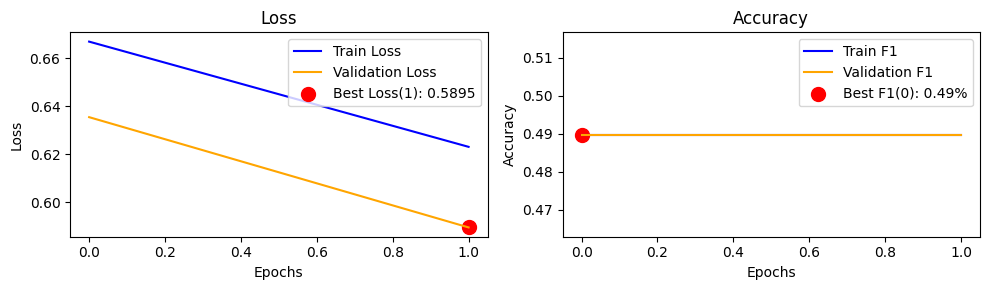

In [49]:
# 시각화
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(list_train_loss, label='Train Loss', color='blue')
plt.plot(list_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
# 최저 손실값에 대한 지점 찾기
best_loss_epoch = list_val_loss.index(min(list_val_loss))
best_loss = min(list_val_loss)
# 최저 손실값에 빨간 점 찍기
plt.scatter(best_loss_epoch, best_loss, color='red', s=100, label=f'Best Loss({best_loss_epoch}): {best_loss:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list_train_f1, label='Train F1', color='blue')
plt.plot(list_val_f1, label='Validation F1', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
# 최저 손실값에 대한 지점 찾기
best_accuracy_epoch = list_val_f1.index(max(list_val_f1))
best_accuracy = max(list_val_f1)
# 최저 손실값에 빨간 점 찍기
plt.scatter(best_accuracy_epoch, best_accuracy, color='red', s=100, label=f'Best F1({best_accuracy_epoch}): {best_accuracy:.2f}%')
plt.legend()

plt.tight_layout()
# 이미지 파일로 저장
plt.savefig(os.path.join(opt.SAVE_OUTPUT, 'result.png'))
plt.show()

# Inference

In [50]:
# import
import os
import re
import json
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F

SAVE_OUTPUT = './output_test'
# 하이퍼파라미터 설정
config_model_vocab_size = 1994
config_model_embed_dim = 256
config_model_num_filters = 128
config_model_filter_sizes = [2, 3, 4, 5]  # 다양한 크기의 필터 사용
config_model_hidden_dim = 256
config_model_output_dim = 2  # binary
config_model_dropout = 0.3
config_model_num_layers = 3
config_model_pad_token=1993  # padding 무시하고 loss를 구하기 위해

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:1")# if torch.cuda.is_available() else "cpu")

# 모델, 손실 함수 및 옵티마이저 정의
# CNN-LSTM 모델 정의
class CharLevelLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes=1, num_layers=1, dropout=0.5):
        super(CharLevelLSTM, self).__init__()
        
        self.num_classes = num_classes
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embed_size)
        x, (h_n, c_n) = self.lstm(x)  # (batch_size, seq_length, hidden_size)
        
        # Apply the fully connected layer to each time step
        x = self.fc(x)  # (batch_size, seq_length, num_classes)
        
        return x.squeeze(-1)  # (batch_size, seq_length)

model = CharLevelLSTM(config_model_vocab_size, config_model_embed_dim, config_model_hidden_dim, config_model_output_dim, config_model_num_layers, config_model_dropout)
model.to(device);
model.load_state_dict(torch.load(os.path.join(SAVE_OUTPUT, 'best_model.pth')));  # Best 상태로 모델을 로드


In [54]:
## config
root_folder = './resources'
vocab_path = os.path.join(root_folder, 'w2idx.dic')
model_path = os.path.join(opt.SAVE_OUTPUT, 'best_model.pth')
max_seq_len = 200

In [55]:
# functions
def pre_processing(setences):
    # 공백은 ^
    char_list = [li.strip().replace(' ', '^') for li in setences]
    # 문장의 시작 포인트 «
    # 문장의 끌 포인트  »
    char_list = ["«" + li + "»" for li in char_list]
    # 문장 -> 문자열
    char_list = [''.join(list(li)) for li in char_list]
    return char_list


def encoding_and_padding(word2idx_dic, sequences, **params):
    """
    1. making item to idx
    2. padding
    :word2idx_dic
    :sequences: list of lists where each element is a sequence
    :maxlen: int, maximum length
    :dtype: type to cast the resulting sequence.
    :padding: 'pre' or 'post', pad either before or after each sequence.
    :truncating: 'pre' or 'post', remove values from sequences larger than
        maxlen either in the beginning or in the end of the sequence
    :value: float, value to pad the sequences to the desired value.
    """
    seq_idx = [[word2idx_dic.get(a, word2idx_dic['__ETC__']) for a in i]
               for i in sequences]
    params['value'] = word2idx_dic['__PAD__']
    return (pad_sequences(seq_idx, **params))


def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word


# 사전 파일 로딩
w2idx, idx2w = load_vocab(vocab_path)  # 1994, w2idx: '엠': 1352

In [56]:
## 추론
def pad_sequences(sequences,
                  maxlen=None,
                  dtype='int32',
                  padding='pre',
                  truncating='pre',
                  value=0.):

    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' %
                             truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError(
                'Shape of sample %s of sequence at position %s is different from expected shape %s'
                % (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

# 추론 함수 정의
def make_pred_sents(x_sents, y_pred):
    res_sent = []
    for i, j in zip(x_sents, y_pred):
        if j == 1:
            res_sent.append(i)
            res_sent.append(' ')
        else:
            res_sent.append(i)
    subs = re.sub(re.compile(r'\s+'), ' ', ''.join(res_sent).replace('^', ' '))
    subs = subs.replace('«', '')
    subs = subs.replace('»', '')
    return subs


def inference(model, input_txt, device):
    model.eval()
    input_txt_processed = pre_processing([input_txt])  # ['«아버지가^방에^들어^가^신다»']
    input_txt_processed_no_space = [tmp.replace('^', '') for tmp in input_txt_processed]  # ['«아버지가방에들어가신다»']
    # input_txt_processed_no_space = [tmp for tmp in input_txt_processed]  # ['«아버지가방에들어가신다»']

    input_txt_processed_indice = encoding_and_padding(word2idx_dic=w2idx,
                                  sequences=input_txt_processed_no_space,
                                  maxlen=max_seq_len,
                                  padding='post',
                                  truncating='post')  # [[   3,   26,  188,   12,   11,  118,    7,   29,   20,   11,   70, 2,   4, 1993, 1993,

    # print(f'{input_txt_processed}\n=>{input_txt_processed_no_space}\n=>{input_txt_processed_indice}')


    model.eval()
    input_ids = torch.tensor(input_txt_processed_indice).to(device)
        
    with torch.no_grad():
        outputs = model(input_ids)
        # Apply softmax to outputs to get probabilities
        probabilities = F.softmax(outputs, dim=-1)  # (batch_size, seq_length, num_classes)
        # Convert outputs to predicted labels by taking the argmax
        predicted_labels = torch.argmax(probabilities, dim=2)  # (batch_size, seq_length)
        predictions = predicted_labels.cpu().numpy().squeeze()

        pad_index_from = np.where(input_txt_processed_indice[0] == 1993)[0][0]
        predictions = predictions[:pad_index_from].tolist()

        result_spacing = make_pred_sents(list(input_txt_processed_no_space[0]), predictions)
        print(f'{input_txt}\n=>{input_txt_processed_no_space}\n=>{result_spacing}\n=>{predictions}')        

    return result_spacing, predictions


# 추론 실행
input_txt = '아 버 지가 방에 들어 가 신다'
result_spacing, predictions = inference(model, input_txt, device)

아 버 지가 방에 들어 가 신다
=>['«아버지가방에들어가신다»']
=>아버지가방에들어가신다
=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# pip pachage

In [57]:
# -*- coding: utf-8 -*-
# import
import os
import re
import argparse
import json
from pprint import pprint
import torch
import torch.nn.functional as F
from utils import CharLevelLSTM, pre_processing, encoding_and_padding, load_vocab, pad_sequences, make_pred_sents, inference

root_folder = './resources'
## config
rules_path = os.path.join(root_folder, 'rules.json')
vocab_path = os.path.join(root_folder, 'w2idx.dic')
model_path = os.path.join(root_folder, 'space_model.pth')

# model_path = pkg_resources.resource_filename(
#     'korspacing', os.path.join('resources', 'space_model.pth'))
# vocab_path = pkg_resources.resource_filename(
#     'korspacing', os.path.join('resources', 'dicts', 'c2v.dic'))

max_seq_len = 200

# 하이퍼파라미터 설정
config_model_vocab_size = 1994
config_model_embed_dim = 256
config_model_num_filters = 128
config_model_filter_sizes = [2, 3, 4, 5]  # 다양한 크기의 필터 사용
config_model_hidden_dim = 256
config_model_output_dim = 2  # binary
config_model_dropout = 0.3
config_model_num_layers = 3
config_model_pad_token=1993  # padding 무시하고 loss를 구하기 위해

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharLevelLSTM(config_model_vocab_size, config_model_embed_dim, config_model_hidden_dim, config_model_output_dim, config_model_num_layers, config_model_dropout)
model.load_state_dict(torch.load(model_path));  # Best 상태로 모델을 로드
model.eval()
model.to(device);

# 사전 파일 로딩
w2idx, idx2w = load_vocab(vocab_path)  # 1994, w2idx: '엠': 1352

In [58]:
## KorSpacing class
class KorSpacing:
    '''
    run korean word spacing by torch
    '''
    def __init__(self, rules=True, verbose=False):
        self.w2idx = w2idx
        self.max_seq_len = max_seq_len
        self.device = device
        self.verbose = verbose        
        self.model = model
        
        # rules가 dictionary면 바로 읽고, 경로면 dictionary를 읽어온다
        if type(rules)==dict:
            self.rules = rules
        elif rules==True:
            with open(rules_path, 'r', encoding='UTF-8') as f_read:
                self.rules = json.load(f_read)
                
        print('## rules ##')
        pprint(self.rules)

    def __call__(self, input_txt):
        
        # 띄어쓰기 제거
        input_txt_nospace = input_txt.replace(" ", "")
        
        if len(input_txt_nospace) > self.max_seq_len:
            splitted_sent = [input_txt_nospace[:self.max_len]]
        else:
            splitted_sent = [input_txt_nospace]
        
        input_txt_processed = pre_processing(splitted_sent)  # ['«아버지가^방에^들어^가^신다»']
        input_txt_processed_no_space = [tmp.replace('^', '') for tmp in input_txt_processed]  # ['«아버지가방에들어가신다»']

        input_txt_processed_indice = encoding_and_padding(word2idx_dic=self.w2idx,
                                      sequences=input_txt_processed_no_space,
                                      maxlen=self.max_seq_len,
                                      padding='post',
                                      truncating='post')  # [[   3,   26,  188,   12,   11,  118,    7,   29,   20,   11,   70, 2,   4, 1993, 1993,
        input_ids = torch.tensor(input_txt_processed_indice).to(device)
        
        # run model
        with torch.no_grad():
            outputs = self.model(input_ids)
            # Apply softmax to outputs to get probabilities
            probabilities = F.softmax(outputs, dim=-1)  # (batch_size, seq_length, num_classes)
            # Convert outputs to predicted labels by taking the argmax
            predicted_labels = torch.argmax(probabilities, dim=2)  # (batch_size, seq_length)
            predictions = predicted_labels.cpu().numpy().squeeze()

            pad_index_from = np.where(input_txt_processed_indice[0] == 1993)[0][0]
            predictions = predictions[:pad_index_from].tolist()

            result_spacing = make_pred_sents(list(input_txt_processed_no_space[0]), predictions)
            
            if self.verbose:
                print(f'{input_txt}\n=>{input_txt_nospace}\n=>{input_txt_processed_no_space}\n=>{result_spacing}\n=>{predictions}')        

        # rule 적용
        if len(self.rules)>0:
#             print('# rule #')
            for word, rgx in rules.items():
                result_spacing = result_spacing.replace(word, rgx)
        
        return result_spacing.strip()

# from korspacing import KorSpacing

rules = {
    '아버지 가방에': '아버지가 방에', 
    '아 버지가방': '아버지가 방',     
}

# spacing = KorSpacing(rules=rules)
spacing = KorSpacing()
result = spacing('아버지가방에들어가신다')
print(result)


## rules ##
{'아버지 가방에': '아버지가 방에'}
아버지가 방 에 들 어 가 신 다


In [59]:
# run
from korspacing import KorSpacing

rules = {
    '아버지 가방에': '아버지가 방에', 
    '아 버지가방': '아버지가 방',     
}

# spacing = KorSpacing(rules=rules)
spacing = KorSpacing()

result = spacing('아버지가방에들어가신다')
print(result)

## rules ##
{'아버지 가방에': '아버지가 방에'}
아버지가 방 에 들 어 가 신 다
## rules ##
{'아버지 가방에': '아버지가 방에'}
아버지가 방 에 들 어 가 신 다


# End